In [1]:
%matplotlib inline

# IF curve

In [2]:
import numpy as np
import nest
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Here we define which model and the neuron parameters to use for measuring
the transfer function.



In [3]:
model = 'iaf_psc_exp'
params_e = {
            # Leak potential of the neurons (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'E_L': -70.0,
            # Threshold potential of the neurons (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'V_th': -45.0,
            # Membrane potential after a spike (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'V_reset': -70.0,
            # Membrane capacitance (in pF).
            # See Allen Cells GLIF Parameters.ipynb
            'C_m': 300.0,
            # Membrane time constant (in ms).
            # See Allen Cells GLIF Parameters.ipynb
            # Lowered to account for high-conductance state.
            'tau_m': 10.0,
            # Time constant of postsynaptic excitatory currents (in ms).
            # Value for AMPA receptors from (Fourcaud & Brunel, 2002)
            'tau_syn_ex': 2.0,
            # Time constant of postsynaptic inhibitory currents (in ms).
            # Value for GABA_A receptors from (Fourcaud & Brunel, 2002)
            'tau_syn_in': 5.0,
            # Refractory period of the neurons after a spike (in ms).
            't_ref': 2.0
            }

params_i = {
            # Leak potential of the neurons (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'E_L': -70.0,
            # Threshold potential of the neurons (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'V_th': -45.0,
            # Membrane potential after a spike (in mV).
            # See Allen Cells GLIF Parameters.ipynb
            'V_reset': -70.0,
            # Membrane capacitance (in pF).
            # See Allen Cells GLIF Parameters.ipynb
            'C_m': 100.0,
            # Membrane time constant (in ms).
            # See Allen Cells GLIF Parameters.ipynb
            # Lowered to account for high-conductance state.
            'tau_m': 10.0,
            # Time constant of postsynaptic excitatory currents (in ms).
            # Value for AMPA receptors from (Fourcaud & Brunel, 2002)
            'tau_syn_ex': 2.0,
            # Time constant of postsynaptic inhibitory currents (in ms).
            # Value for GABA_A receptors from (Fourcaud & Brunel, 2002)
            'tau_syn_in': 5.0,
            # Refractory period of the neurons after a spike (in ms).
            't_ref': 2.0
            }

In [4]:
class IF_curve():

    t_sim = 1000.         # Duration of a measurement trial
    n_neurons = 100       # Number of neurons
    n_threads = 4         # Nubmer of threads to run the simulation

    def __init__(self, model, params=False):
        self.model = model
        self.params = params
        self.build()
        self.connect()

    def build(self):
        #######################################################################
        #  We reset NEST to delete information from previous simulations
        # and adjust the number of threads.

        nest.ResetKernel()
        nest.SetKernelStatus({'local_num_threads': self.n_threads})

        #######################################################################
        # We set the default parameters of the neuron model to those
        # defined above and create neurons and devices.

        if self.params:
            nest.SetDefaults(self.model, self.params)
        self.neuron = nest.Create(self.model, self.n_neurons)
        self.spike_detector = nest.Create('spike_recorder')

    def connect(self):
        #######################################################################
        # We connect the neurons to the spike detectors.

        nest.Connect(self.neuron, self.spike_detector, 'all_to_all')

    def output_rate(self, mean):
        self.build()
        self.connect()
        nest.SetStatus(self.neuron, "I_e", mean)
        nest.Simulate(self.t_sim)
        rate = nest.GetStatus(self.spike_detector, 'n_events')[0] * 1000.0 \
            / (1. * self.n_neurons * self.t_sim)
        return rate

    def compute_transfer(self, i_mean=(400.0, 900.0, 50.0)):
        #######################################################################
        # We loop through all possible combinations of `(I_mean, I_sigma)`
        # and measure the output rate of the neuron.

        self.i_range = np.arange(*i_mean)
        self.rate = np.zeros(self.i_range.size)
        nest.set_verbosity('M_WARNING')
        for n, i in enumerate(self.i_range):
#             print('I  =  {0}'.format(i))
            self.rate[n] = self.output_rate(i)

In [5]:
transfer_e = IF_curve(model, params_e)
transfer_e.compute_transfer(i_mean=(0.0,1500.0,10.0))

transfer_i = IF_curve(model, params_i)
transfer_i.compute_transfer(i_mean=(0.0,1500.0,10.0))

Ploting the FxI curve:



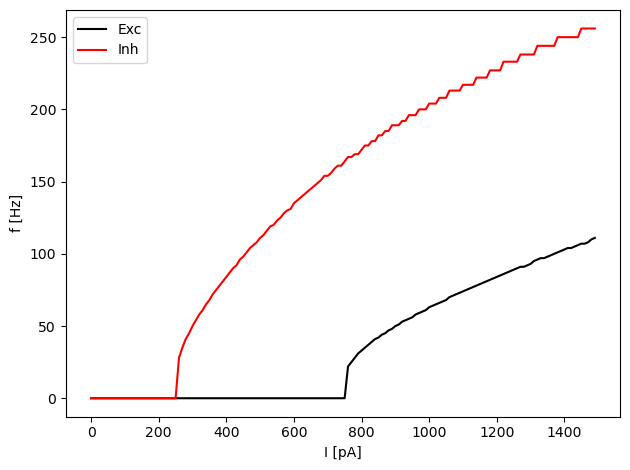

In [6]:
plt.plot(transfer_e.i_range, transfer_e.rate, label='Exc', color='k')
plt.plot(transfer_i.i_range, transfer_i.rate, label='Inh', color='r')
plt.xlabel('I [pA]')
plt.ylabel('f [Hz]')
# plt.xlim(0,300)
plt.legend()
plt.tight_layout()